# Reinforce (Monte Carlo Policy Gradient)

策略梯度算法的损失函数如下：
$$
J_{\theta}= \Psi_{\pi} \nabla_\theta \log \pi_\theta\left(a_t \mid s_t\right)
$$

我们需要拆开成两个部分$\Psi_{\pi}$和$\nabla_\theta \log \pi_\theta\left(a_t \mid s_t\right)$分开计算，首先看值函数部分$\Psi_{\pi}$，在REINFORCE算法中值函数是从当前时刻开始的衰减回报，如下：
$$
G \leftarrow \sum_{k=t+1}^{T} \gamma^{k-1} r_{k}
$$
实际REINFORCE算法所实现的就是：不断提升那些回报为正的动作的概率，降低那些回报为负的动作的概率，使网络可以尽可能输出那些回报高的动作概率空间。

动态规划技巧：

我们可以倒过来看，在同一回合下，我们的终止时刻是$T$，那么对应的回报$G_T=\gamma^{T-1}r_T$，而对应的$G_{T-1}=\gamma^{T-2}r_{T-1}+\gamma^{T-1}r_T$，在这里代码中我们使用了一个动态规划的技巧，如下：
```python
running_add = running_add * self.gamma + reward_pool[i] # running_add初始值为0
```
这个公式也是倒过来循环的，第一次的值等于：
$$
running\_add = r_T
$$
第二次的值则等于：
$$
running\_add = r_T*\gamma+r_{T-1}
$$
第三次的值等于：
$$
running\_add = (r_T*\gamma+r_{T-1})*\gamma+r_{T-2} = r_T*\gamma^2+r_{T-1}*\gamma+r_{T-2}
$$

### Importinggym and other important libraries

In [1]:
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical       # 离散概率分布 

from collections import deque                     # 标准库中的一个类，它实现双端队列，允许从两端进行插入和删除操作，而不需要移动元素。
import numpy as np

import imageio                                  # imageio 是一个用于读写图像和视频的 Python 库

import matplotlib.pyplot as plt
import time

###  Check if we have gpu

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Making env

In [3]:
env_id = "CartPole-v1"    # flappy bird env id

env = gym.make(env_id, render_mode='rgb_array')      # creating the env
eval_env = gym.make(env_id, render_mode='rgb_array')     # creating the eval env
env.reset(seed=42)
eval_env.reset(seed=42)

s_size = env.observation_space.shape[0]     # observation space
a_size = env.action_space.n                 # action space

In [4]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

### Observation Space

In [5]:
print("_____OBSERVATION SPACE_____ \n")
print(f"Observation Space: {env.observation_space}")                  # 12维的连续动作空间，没有上下界
print(f"Sample Observation Space: {env.observation_space.sample()}")  # 随机抽几个样看一下

_____OBSERVATION SPACE_____ 

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Sample Observation Space: [ 2.7967052e+00 -3.0792509e+38 -1.2728517e-01  1.4831803e+38]


####  Observation
- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

In [6]:
print("_____ACTION SPACE_____ \n")
print(f"Action Space: {env.action_space}")                  # 动作空间只有两个离散的动作
print(f"Sample Action Space: {env.action_space.sample()}")

_____ACTION SPACE_____ 

Action Space: Discrete(2)
Sample Action Space: 1


#### The action space(2):
- `1`: Left 
- `0`: Right

### Reward Function:
- `+1.0` - Every Second

## Defining the Policy_Network

In [7]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):       
        super(Policy, self).__init__()                # 使子类Policy继承神经网络父类的方法和属性
        ## Creating Layers
        # Hidden Layers
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size*2)
        # Output Layer
        self.fc3 = nn.Linear(h_size*2, a_size)

    # Define the Forward Pass
    def forward(self, x):
        # apply relu activation function to the hidden layers
        x = F.relu(self.fc1(x))                       # 负值直接为0，可以使稀疏后的模型能够更好地挖掘相关特征，加速学习
        x = F.relu(self.fc2(x))
        # output with softmax
        x = F.softmax(self.fc3(x), dim = 1)                    # 归一化指数函数，多分类问题必用；  dim = 1表示在行维度上使用softmax   , dim=1
        return x                                      # x[0] 就包含第一个样本在所有类别上的概率分布
    
    # Define the act i.e. given a state, take action
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)   #from_numpy   pytorch搭建的网络不接受一维张量输入,unsqueeze(0)增加一个维度;  因为Net想要的是一批数据，一批自然是两维，但如果只是一个的话就需要扩展维度。 
        probs = self.forward(state).cpu()                                 # 模型的计算可能在 GPU 上进行，将结果移回到 CPU 上进行后续处理或者与其他 CPU 上的数据进行交互。
        m = Categorical(probs)
        action = m.sample()                                   # 从每个动作的概率抽取，返回一个值
        return action.item(), m.log_prob(action)              # 将抽取的动作及其对数概率作为结果返回; action.item()从tensor转换为int标量值

## Building the Reinforce Algorithm
Building the Monte Carlo Policy Gradient (MCPG) or Reinforce Algorithm

In [8]:
##########
baseline = 0
losses = []
##########
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)                        # 创建长度为100的双端队列
    scores = []

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)                       # 储存所有的对数概率   
            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)                                 # 把每步的reward都存起来了
            if terminated:
                rewards[-1] = -1.1
                break 
        if t==max_t-1:
            rewards = rewards*100000
        scores_deque.append(sum(rewards))                          # 把这次的累计得分存储起来
        scores.append(sum(rewards))                                

        returns = deque(maxlen=max_t) 
        n_steps = len(rewards)                                    # 这个rewards的长度应该和max_t不一致，因为可能会terminated
        for t in range(n_steps)[::-1]:
             disc_return_t = (returns[0] if len(returns)>0 else 0)     # 要把初始Reward(t=maxt+1)设为0，这样的话Return(t=max)时才是正常的，只等于自己的reward，动态规划才能正常开始.
             returns.appendleft( gamma*disc_return_t + rewards[t]   )  # 动态规划了，计算每个时刻t下的回报。 这里是从后往前算; 从前插入，先进的在后面;
                                                                      ## 因为如果正着算的话很繁琐，r+y(rt+1)+...
        
        # standardizing returns to make traininig more stable         # 将回报标准化，这样就会有正有负，加快收敛。（问题是有时已经最好了，还会去削减一些动作。）
        #eps = np.finfo(np.float32).eps.item()         # smallest representable float  获取 np.float32 类型的最小正浮点数
        #returns = torch.tensor(returns)
        #returns = (returns - returns.mean()) / (returns.std()+eps)    # added to std deviation to avoid numerical instabilities

        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * (disc_return - baseline))               # REINFORCE的损失函数    # 原文是 -log_prob * disc_return，因为默认梯度下降为“-”，加上负号就是梯度上升。   当输出负的回报时，就会导致梯度还是往下走，导致出现该动作的可能降低。 
                                                                     
        
        policy_loss = torch.cat(policy_loss).sum()                    # 求和，作为一个epoch的结果。

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        ########
        losses.append(policy_loss.item())
        ########
        if i_episode % (print_every/100) == 0:       # 就是每10轮打印一次
            print(f"Episode: {i_episode}\tAverage Score: {scores[-1]}\tPolicy Loss: {policy_loss.item()}")   # 打印第几轮训练，平均得分，以及损失
        # print(f"Episode: {i_episode}\tScore: {scores_deque[-1]}\tPolicy Loss: {policy_loss.item()}")   # 打印第几轮训练，平均得分，以及损失
        
    return scores

## Definig Hyperparameters

In [9]:
rewards[-1] = -1.5
"gamma": .9,                     
"lr": 3e-3,                       

rewards[-1] = -1.5
"gamma": .9,                     # 折扣因子0.99
"lr": 1e-2,                       # 优化器的学习率

SyntaxError: illegal target for annotation (2008173902.py, line 2)

In [10]:
losses = []
CartPole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 500,     # 训练轮
    "n_evaluation_episodes": 10,      # 验证1000轮
    "max_t": 300,                    # 每轮走1000步
    "gamma": .9,                     # 折扣因子0.99
    "lr": 6e-3,                       # 优化器的学习率
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [11]:
Policy(s_size, a_size, CartPole_hyperparameters['h_size'])

Policy(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

## Training the Agent

In [12]:
CartPole_policy = Policy(CartPole_hyperparameters["state_space"], CartPole_hyperparameters["action_space"], CartPole_hyperparameters["h_size"]).to(device)
CartPole_optimizer = optim.Adam(CartPole_policy.parameters(), lr=CartPole_hyperparameters["lr"])    #  优化器

In [13]:
scores = reinforce(
    CartPole_policy,
    CartPole_optimizer,
    CartPole_hyperparameters["n_training_episodes"],
    CartPole_hyperparameters["max_t"],
    CartPole_hyperparameters["gamma"],
    1000)

Episode: 10	Average Score: 20.9	Policy Loss: 86.65543365478516
Episode: 20	Average Score: 14.9	Policy Loss: 50.98039627075195
Episode: 30	Average Score: 24.9	Policy Loss: 126.40762329101562
Episode: 40	Average Score: 6.9	Policy Loss: 12.973165512084961
Episode: 50	Average Score: 15.9	Policy Loss: 56.76408767700195
Episode: 60	Average Score: 21.9	Policy Loss: 92.37242126464844
Episode: 70	Average Score: 14.9	Policy Loss: 52.41143798828125
Episode: 80	Average Score: 36.9	Policy Loss: 187.6076202392578
Episode: 90	Average Score: 29.9	Policy Loss: 143.3388214111328
Episode: 100	Average Score: 30.9	Policy Loss: 139.36534118652344
Episode: 110	Average Score: 19.9	Policy Loss: 82.27539825439453
Episode: 120	Average Score: 17.9	Policy Loss: 71.16641235351562
Episode: 130	Average Score: 55.9	Policy Loss: 277.83612060546875
Episode: 140	Average Score: 51.9	Policy Loss: 241.62503051757812
Episode: 150	Average Score: 27.9	Policy Loss: 116.12922668457031
Episode: 160	Average Score: 18.9	Policy Loss

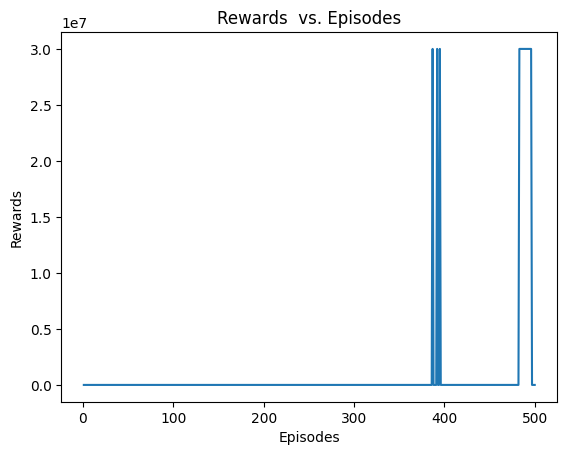

In [15]:
# Plotting the policy loss with episodes
plt.plot(range(1, CartPole_hyperparameters["n_training_episodes"]+1), scores)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards  vs. Episodes')
plt.show()

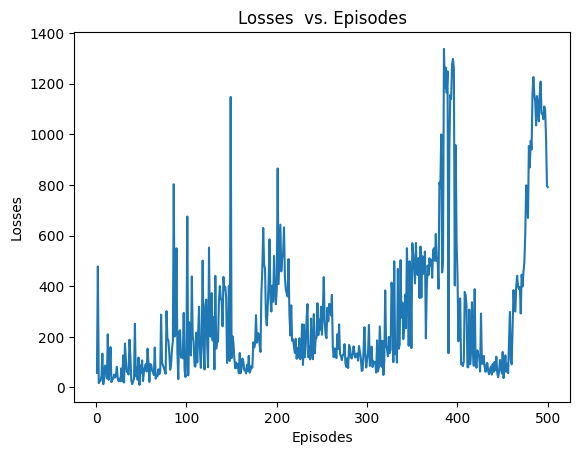

In [16]:
# Plotting the policy loss with episodes
plt.plot(range(1, CartPole_hyperparameters["n_training_episodes"]+1), losses)
plt.xlabel('Episodes')
plt.ylabel('Losses')
plt.title('Losses  vs. Episodes')
plt.show()

## Define Evaluation Agent

In [17]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset(seed=42)
    state = state[0]
    step = 0
    # terminated = False
    # truncated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

#### Evaluate our Agent

In [20]:
evaluate_agent(eval_env,
               CartPole_hyperparameters["max_t"],
               CartPole_hyperparameters["n_evaluation_episodes"],
               CartPole_policy)

(213.9, 13.670771741200275)

### Recording Video

In [162]:
def record_video(env, policy, out_directory, fps=30):
  images = []
  terminated = False
  truncated = False
  state = env.reset(seed=42)
  state = state[0]
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    action, _ = policy.act(state)
    state, reward, terminated, truncated, info = env.step(action)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [163]:
video_path = './replay.mp4'
record_video(eval_env, CartPole_policy, video_path, 30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [301]:
flappy_bird_gymnasium

<module 'flappy_bird_gymnasium' from 'C:\\Users\\lenovo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\flappy_bird_gymnasium\\__init__.py'>

In [302]:
env.step(1)

(array([ 0.83333333,  0.31445312,  0.50976562,  1.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  1.        , -0.15820312,
         0.1       ,  0.16666667]),
 0.1,
 False,
 False,
 {'score': 0})

In [303]:
# standardizing returns to make traininig more stable         # 将回报标准化 ??
eps = np.finfo(np.float32).eps.item()         # smallest representable float  获取 np.float32 类型的最小正浮点数
returns = torch.tensor(100).float()
(returns.std()+eps)    

tensor(nan)